In [702]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MultiLabelBinarizer

In [703]:
df_test = pd.read_csv("../Data/test_gr/test.csv")
df_train = pd.read_csv("../Data/train_gr/train.csv")
df_overview = pd.read_csv("../Data/train_gr/game_overview.csv")
df_train.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [704]:
df_train[(df_train["title"] == "PlanetSide 2") & (df_train["user_suggestion"] == 1)]

,review_id,title,year,user_review,user_suggestion
8890,11900,PlanetSide 2,2018.0,"Planetside 2 is truly stunning,It features a m...",1
8891,11901,PlanetSide 2,2014.0,"When i first started playing this game, I thou...",1
8892,11902,PlanetSide 2,2014.0,Good for people that like to mash themselfs en...,1
8894,11904,PlanetSide 2,2014.0,Note: to see this review in its true form go t...,1
8895,11905,PlanetSide 2,2016.0,£1 per hour is considered good value yeah? Wel...,1
...,...,...,...,...,...
9356,12366,PlanetSide 2,2018.0,PROSUnique combined arms MMOFPSCompletely free...,1
9357,12367,PlanetSide 2,2018.0,"6/10Pretty good gunfights, though sometimes my...",1
9358,12368,PlanetSide 2,2014.0,This is pretty awesome. Im no full time Fps fa...,1
9359,12369,PlanetSide 2,2018.0,[I am only stating my personal opinion in this...,1


In [705]:
#group training data by title and aggregate the mean of the user_suggestion
d = df_train.groupby([df_train["title"]], as_index=False).agg({"user_suggestion": "mean"}).sort_values(by="user_suggestion", ascending=False)
d.head()


,title,user_suggestion
14,EverQuest II,0.971014
16,Fractured Space,0.958217
21,Path of Exile,0.906114
6,Creativerse,0.900407
22,PlanetSide 2,0.896186


In [706]:
#join the training and overview data into an array
df_join = [d, df_overview]
#convert array into data frame
df_join = pd.concat(df_join)

#group by title and ensure that other relevant columns are preserved. Everything else is dropped
df_join = df_join.groupby(["title"]).agg({"user_suggestion": "mean", "tags": "first"}).reset_index().sort_values(by="user_suggestion", ascending=False)
df_join.head()

,title,user_suggestion,tags
20,EverQuest II,0.971014,"['Free to Play', 'Massively Multiplayer', 'RPG..."
23,Fractured Space,0.958217,"['Space', 'Multiplayer', 'Free to Play', 'PvP'..."
34,Path of Exile,0.906114,"['Free to Play', 'Action RPG', 'Hack and Slash..."
9,Creativerse,0.900407,"['Free to Play', 'Survival', 'Open World', 'Mu..."
35,PlanetSide 2,0.896186,"['Free to Play', 'Massively Multiplayer', 'FPS..."


genre = []
#iterate through tags column and concat into a single dataframe
for i, row in ov_filtered["tags"].items():
    df = row.replace("[", "").replace("]", "").replace("'", "")
    ov_filtered["tags"][i] = df
    genre = genre + df.split(", ")
df_genre = pd.DataFrame(data=genre)
#df_overview["tags"].head()
df_genre.value_counts()

#match_df = d["title"].isin(ov_filtered["title"])
d["tags"] = np.nan
for i, row in d.iterrows():
    s = row["title"]
    tag = ov_filtered.loc[ov_filtered["title"] == s]
    d["tags"][i] = tag["tags"].item()
d

In [707]:
df_nan = df_join[~(df_join["user_suggestion"] <= 1)]
df_nan_encoded = df_join[~(df_join["user_suggestion"] <= 1)]
df_final = df_join.copy(deep=True)
df_encoded = df_join.copy(deep=True)
df_final = df_final.dropna()
df_encoded = df_encoded.dropna()

In [708]:
le = LabelEncoder()
oe = OrdinalEncoder().set_output(transform="pandas")
df_encoded["title"] = le.fit_transform(df_encoded["title"])
df_nan_encoded["title"] = le.fit_transform(df_nan_encoded["title"])
df_encoded.head()

C:\Users\dylan\AppData\Local\Temp\ipykernel_7852\140565259.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan_encoded["title"] = le.fit_transform(df_nan_encoded["title"])


,title,user_suggestion,tags
20,14,0.971014,"['Free to Play', 'Massively Multiplayer', 'RPG..."
23,16,0.958217,"['Space', 'Multiplayer', 'Free to Play', 'PvP'..."
34,21,0.906114,"['Free to Play', 'Action RPG', 'Hack and Slash..."
9,6,0.900407,"['Free to Play', 'Survival', 'Open World', 'Mu..."
35,22,0.896186,"['Free to Play', 'Massively Multiplayer', 'FPS..."


In [709]:
genre = []
#iterate through tags column and concat into a single dataframe
for i, row in df_overview["tags"].items():
    df = row.replace("[", "").replace("]", "").replace("'", "")
    df_overview["tags"][i] = df
    genre = genre + df.split(", ")
df_genre = pd.DataFrame(data=genre)
df_genre.value_counts()

Free to Play             63
Multiplayer              61
Action                   54
Massively Multiplayer    48
Co-op                    42
                         ..
City Builder              1
Side Scroller             1
Cartoony                  1
Cartoon                   1
Real-Time                 1
Name: count, Length: 161, dtype: int64

In [710]:
final_str = df_final.copy(deep=True)
encoded_str = df_encoded.copy(deep=True)

for i, row in df_final["tags"].items():
    df = row.replace("[", "").replace("]", "").replace("'", "")
    df = df.split(", ")[:5]
    
    #make tags an array of strings
    df_final["tags"][i] = df
    df_encoded["tags"][i] = df

    #make tags one big string
    final_str["tags"][i] = ' '.join(df)
    encoded_str["tags"][i] = ' '.join(df)
encoded_str

C:\Users\dylan\AppData\Local\Temp\ipykernel_7852\977734318.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded["tags"][i] = df
C:\Users\dylan\AppData\Local\Temp\ipykernel_7852\977734318.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_str["tags"][i] = ' '.join(df)
C:\Users\dylan\AppData\Local\Temp\ipykernel_7852\977734318.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_str["tags"][i] = ' '.join(df)
C:

,title,user_suggestion,tags
20,14,0.971014,Free to Play Massively Multiplayer RPG MMORPG ...
23,16,0.958217,Space Multiplayer Free to Play PvP MOBA
34,21,0.906114,Free to Play Action RPG Hack and Slash RPG Mul...
9,6,0.900407,Free to Play Survival Open World Multiplayer B...
35,22,0.896186,Free to Play Massively Multiplayer FPS Shooter...
50,34,0.894737,Free to Play Strategy Multiplayer Turn-Based RPG
48,33,0.886740,Horror Free to Play Cute First-Person Singlepl...
40,27,0.875895,Early Access Free to Play Battle Royale Shoote...
5,4,0.865854,Free to Play Multiplayer Fighting 2D 2D Fighter
47,32,0.865385,Free to Play Simulation Casual Strategy RPG


<Axes: xlabel='title', ylabel='user_suggestion'>

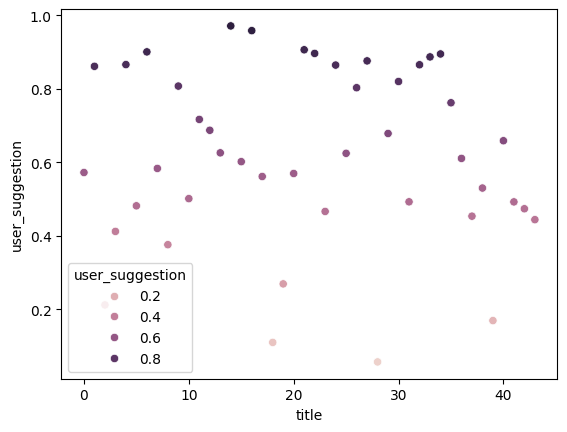

In [747]:
sns.scatterplot(data=df_encoded, x="title", y="user_suggestion", hue="user_suggestion")

In [742]:
#sample_fps = [row for i, row in df_encoded["tags"].items() if 'RPG' in row]
#sample_fps
sample_fps = encoded_str[encoded_str["tags"].str.contains("FPS", case=False)]
sample_rpg = encoded_str[encoded_str["tags"].str.contains("RPG", case=False)]
sample_horror = encoded_str[encoded_str["tags"].str.contains("Horror", case=False)]


<Axes: xlabel='title', ylabel='user_suggestion'>

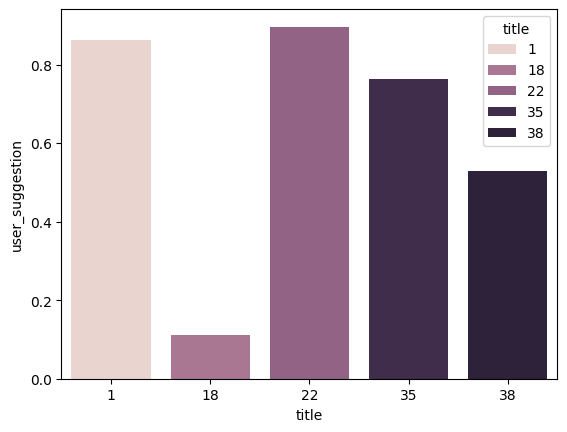

In [713]:
sns.barplot(data=sample_fps, x="title", y="user_suggestion", hue="title")

In [714]:
encoded_str[encoded_str["tags"].str.contains("Multiplayer", case=False) & encoded_str["tags"].str.contains("Free to Play", case=False) & encoded_str["tags"].str.contains("Action", case=False)]

,title,user_suggestion,tags
34,21,0.906114,Free to Play Action RPG Hack and Slash RPG Mul...
35,22,0.896186,Free to Play Massively Multiplayer FPS Shooter...
51,35,0.762004,Free to Play Multiplayer FPS Action Shooter
16,11,0.716667,Free to Play Space Action Massively Multiplaye...
42,29,0.678414,Free to Play MOBA Multiplayer Action Third Person
60,41,0.492355,Tanks Free to Play Multiplayer Action World Wa...
4,3,0.412017,Free to Play Tower Defense Multiplayer Strateg...
41,28,0.057007,Free to Play Robots Building Multiplayer Action


In [718]:
#sample_fps = df_final[df_final["tags"].str.contains("FPS", case=False)]
#sample_co = df_final[df_final["tags"].str.contains("Co-op", case=False)]
#sample_horror = df_final[df_final["tags"].str.contains("Horror", case=False)]

In [720]:
genre = []
for i, row in df_encoded.iterrows():
    genre = genre + row["tags"]
genre = list(dict.fromkeys(genre))


In [750]:
#get mean user suggestion for every tag, then plot them as x=tag and y=user_suggestion
sample_fps = encoded_str[encoded_str["tags"].str.contains("FPS", case=False)]
sample_rpg = encoded_str[encoded_str["tags"].str.contains("RPG", case=False)]
sample_ftp = encoded_str[encoded_str["tags"].str.contains("Free to Play", case=False)]

fps_mean = sample_fps["user_suggestion"].mean()
rpg_mean = sample_rpg["user_suggestion"].mean()
ftp_mean = sample_ftp["user_suggestion"].mean()

print(fps_mean)
print(rpg_mean)
print(ftp_mean)

0.6318737682496762
0.7345771352330808
0.6315716603167194


In [751]:
df = {"genre": ["FPS", "RPG", "Free to Play"], "user_suggestion_mean": [fps_mean, rpg_mean, ftp_mean]}
df = pd.DataFrame(data=df)
df

,genre,user_suggestion_mean
0,FPS,0.631874
1,RPG,0.734577
2,Free to Play,0.631572


<Axes: xlabel='genre', ylabel='user_suggestion_mean'>

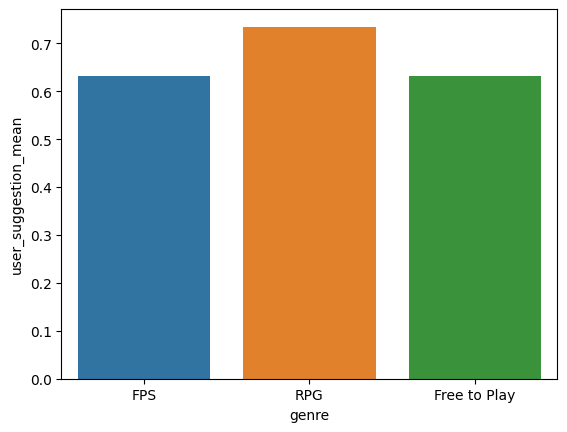

In [752]:
sns.barplot(data=df, x="genre", y="user_suggestion_mean", hue="genre")

<Axes: xlabel='genre', ylabel='user_suggestion_mean'>

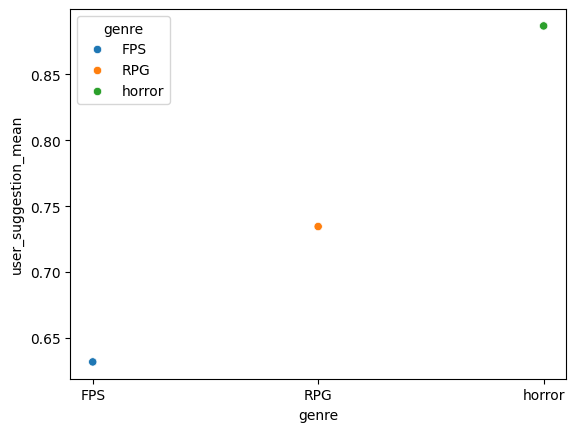

In [743]:
sns.scatterplot(data=df, x="genre", y="user_suggestion_mean", hue="genre")